# Cleaning Ticks Datasets

We will create a new file with the cleaned data for several reasons. The most important is that in the backtesting session, we will take the ticks with outliers if they do not come from an error.

<br>

## Basic consideration

- Order the ticks in a chronological order
- Verify that you do not have null or negative prices or volume 
- Never have a bid higher than the ask


## Detect outliers
- We need to remove the outliers from our data to find more easily good relationship later between variables (but keep the original values with outliers for the backtesting)

In [295]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [296]:
df = pd.read_parquet("../../../EURUSD-Z-Admiral-Markets/2014/01/02.parquet")

<br>

### Order the ticks in a chronological order

In [297]:
# Sort index by chronological order
df = df.sort_index(ascending = True)

# We reset thte index because the dates are not unique
df = df.reset_index(drop=False)

df

,time,bid,ask
0,2014-01-02 00:00:00+00:00,1.37654,1.37660
1,2014-01-02 00:00:00+00:00,1.37654,1.37660
2,2014-01-02 00:00:00+00:00,1.37644,1.37657
3,2014-01-02 00:00:00+00:00,1.37644,1.37657
4,2014-01-02 00:00:00+00:00,1.37646,1.37658
...,...,...,...
170646,2014-01-02 23:59:58+00:00,1.36653,1.36659
170647,2014-01-02 23:59:59+00:00,1.36650,1.36657
170648,2014-01-02 23:59:59+00:00,1.36650,1.36657
170649,2014-01-02 23:59:59+00:00,1.36650,1.36658


<br>

### Verify that you do not have null or negative prices or volumes

In [298]:
# We extract the errors index
index_errors = list(df.loc[(df["bid"]<=0) | (df["ask"]<=0)].index)
df = df.drop(index_errors, axis=0, inplace=False)
df

N Rows dropped


,time,bid,ask
0,2014-01-02 00:00:00+00:00,1.37654,1.37660
1,2014-01-02 00:00:00+00:00,1.37654,1.37660
2,2014-01-02 00:00:00+00:00,1.37644,1.37657
3,2014-01-02 00:00:00+00:00,1.37644,1.37657
4,2014-01-02 00:00:00+00:00,1.37646,1.37658
...,...,...,...
170646,2014-01-02 23:59:58+00:00,1.36653,1.36659
170647,2014-01-02 23:59:59+00:00,1.36650,1.36657
170648,2014-01-02 23:59:59+00:00,1.36650,1.36657
170649,2014-01-02 23:59:59+00:00,1.36650,1.36658


<br>

### Verify that the bid price is never above the ask price

In [299]:
index_errors = list(df.loc[df["ask"]< df["bid"]].index)
df = df.drop(index_errors, axis=0, inplace=False)
df

N Rows dropped


,time,bid,ask
0,2014-01-02 00:00:00+00:00,1.37654,1.37660
1,2014-01-02 00:00:00+00:00,1.37654,1.37660
2,2014-01-02 00:00:00+00:00,1.37644,1.37657
3,2014-01-02 00:00:00+00:00,1.37644,1.37657
4,2014-01-02 00:00:00+00:00,1.37646,1.37658
...,...,...,...
170646,2014-01-02 23:59:58+00:00,1.36653,1.36659
170647,2014-01-02 23:59:59+00:00,1.36650,1.36657
170648,2014-01-02 23:59:59+00:00,1.36650,1.36657
170649,2014-01-02 23:59:59+00:00,1.36650,1.36658


<br>

### Outliers detection

In [300]:
def is_outlier(s, k=5, gamma=0):
    s = s.reset_index(drop=True)
    center_value = s.iloc[k]
    trimmed_s = s[~s.index.isin([k])]
    trimmed_mean = trimmed_s.mean()
    std_dev = trimmed_s.std()
    return abs(center_value - trimmed_mean) > 3 * std_dev + gamma


# Parameters
k = 5  # Window size --> 2*k + 1
gamma = 0.00005  # Granularity (security threshold to avoid finding outliers which are not especially when the volatility is very low)

In [301]:
# We apply the is_outlier fonction
outliers_mask_bid = df['bid'].rolling(window=2*k+1, center=True).apply(
    lambda s: is_outlier(s, k, gamma), raw=False)

outliers_index_bid = outliers_mask_bid[outliers_mask_bid == 1].index


outliers_mask_ask = df['ask'].rolling(window=2*k+1, center=True).apply(
    lambda s: is_outlier(s, k, gamma), raw=False)
outliers_index_ask = outliers_mask_ask[outliers_mask_ask == 1].index


In [302]:
outliers_index = list(outliers_index_bid)
outliers_index.extend(list(outliers_index_ask))
outliers_index

[76869, 75093]

In [303]:
df_clean = df.drop(outliers_index, axis=0, inplace=False)

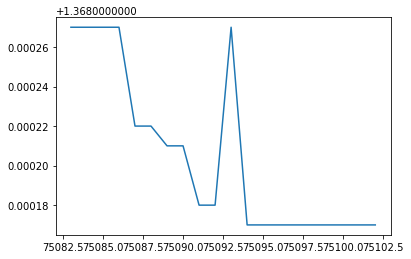

In [305]:
i = 75093
plt.plot(df.iloc[i-10:i+10,:]["bid"])

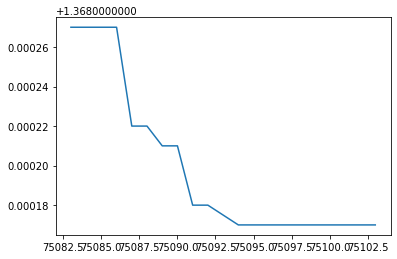

In [306]:
i = 75093
plt.plot(df_clean.iloc[i-10:i+10,:]["bid"])

In [258]:
df_clean = df_clean.set_index("time")
df_clean

,bid,ask
time,,
2014-01-02 00:07:01,1.37554,1.37647
2014-01-02 00:07:07,1.37552,1.37647
2014-01-02 00:07:07,1.37552,1.37647
2014-01-02 00:07:32,1.37553,1.37647
2014-01-02 00:07:32,1.37553,1.37647
...,...,...
2014-01-02 23:57:49,1.36692,1.36700
2014-01-02 23:57:58,1.36690,1.36700
2014-01-02 23:57:58,1.36690,1.36700
